In [ ]:
import os
import uuid
from pathlib import Path

from dotenv import load_dotenv

from azureml.core import Environment, Model, Workspace
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


version = str(uuid.uuid4())[:4]

source_directory = "./azureml"
experiment_name = "oc-p8-experiment-1"

model_names = [
    # "unet_xception_64_augment",
    # "deeplab_v3plus_80_augment",
    # "unet_xception_128",
    # "deeplab_v3plus_160",
    # "unet_xception_256_augment",
    "deeplab_v3plus_320_augment",
    "unet_xception_512",
    "deeplab_v3plus_640",
]


# connect to your workspace
ws = Workspace(
    subscription_id=AZURE_SUBSCRIPTION_ID,
    resource_group=AZURE_RESOURCE_GROUP,
    workspace_name=AZURE_WORKSPACE_NAME,
)


env_name = experiment_name + "-predict"
try:
    env = Environment.get(workspace=ws, name=env_name)
except:
    env = Environment.from_conda_specification(
        name=env_name,
        file_path=Path(source_directory, "conda_dependencies.yml"),
    )
    env.inferencing_stack_version = "latest"
    env.register(workspace=ws)


inference_config = InferenceConfig(
    source_directory=source_directory,
    entry_script="predict.py",
    environment=env,
)


for model_name in model_names:
    aci_config = AciWebservice.deploy_configuration(
        cpu_cores=3.8,
        memory_gb=15,
        scoring_timeout_ms=10 * 60 * 1000,  # 10 minutes
        auth_enabled=True,
    )

    model = Model(ws, model_name)

    service = Model.deploy(
        workspace=ws,
        name=model_name.replace("_", "-") + "-" + version,
        models=[model],
        inference_config=inference_config,
        deployment_config=aci_config,
        overwrite=True,
    )

    service.wait_for_deployment(show_output=True)


Sending request... Endpoint :  http://1db88e73-bf06-4b47-86b7-7c693091eb89.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


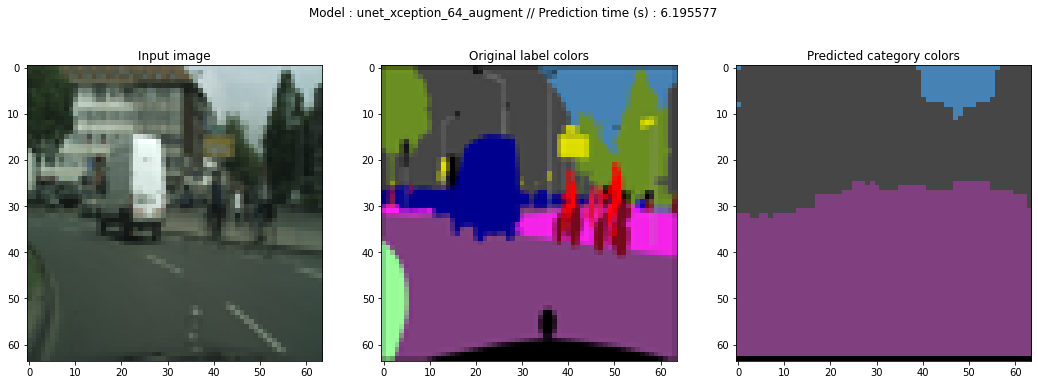

Sending request... Endpoint :  http://af060cd8-3b6f-4a7d-8913-19447a442a30.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


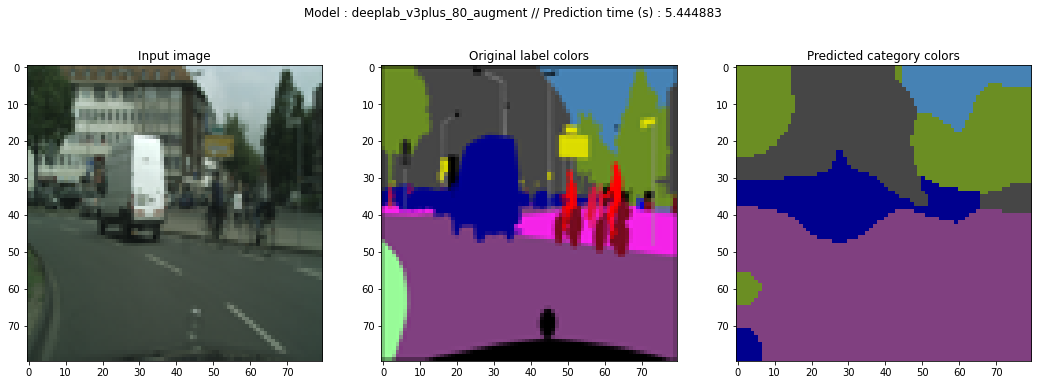

Sending request... Endpoint :  http://f4ae3ebb-874b-442f-8ffd-680e5295c8d3.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


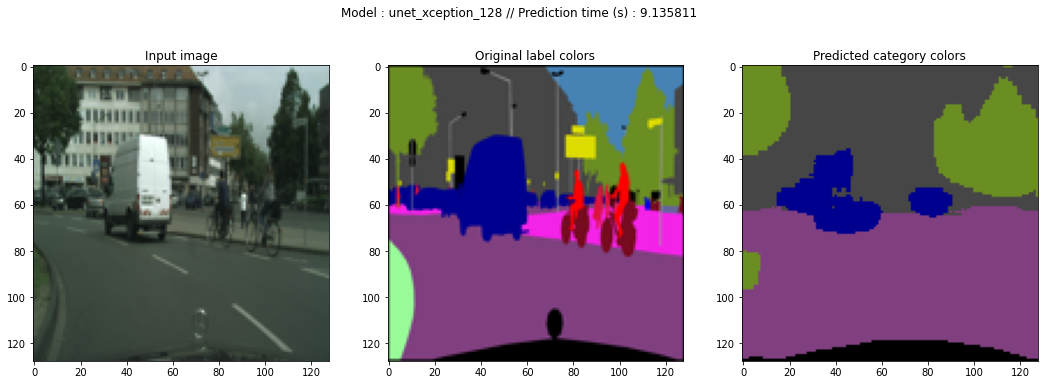

Sending request... Endpoint :  http://a20c292d-3ce3-43c7-8530-1cc6edb9b30b.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


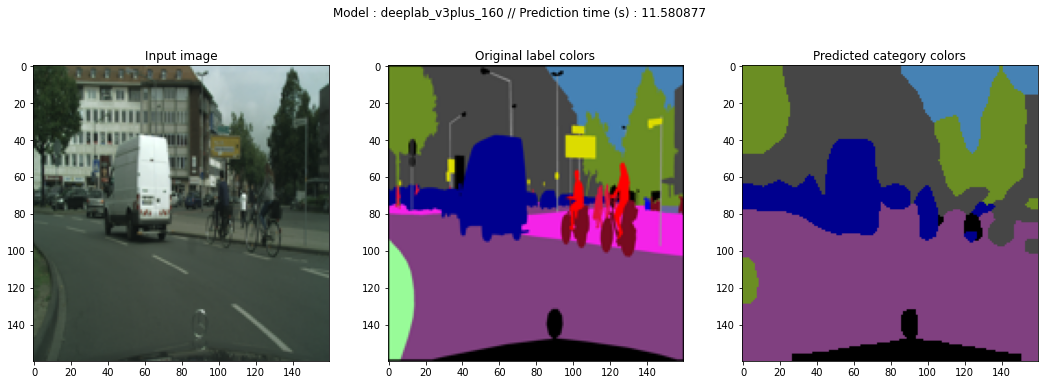

Sending request... Endpoint :  http://107de6a0-53e8-4b54-9f6b-f7aced07a6e7.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


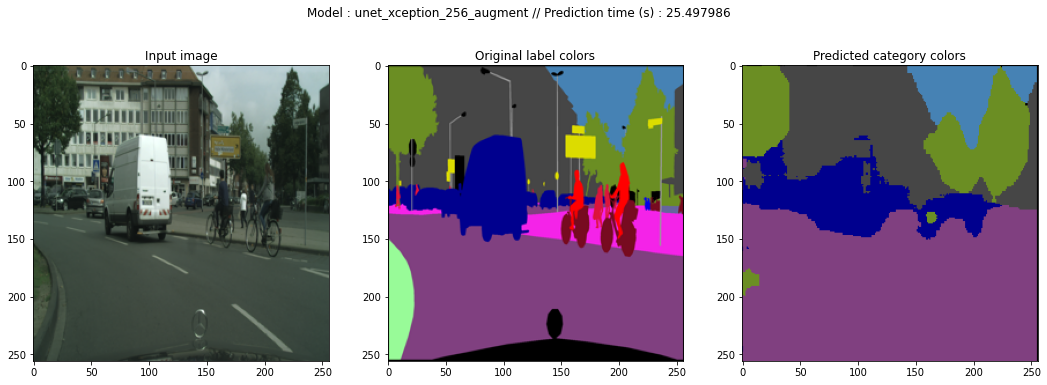

Sending request... Endpoint :  http://2c4d56b4-ba11-4228-8238-91572f41de41.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


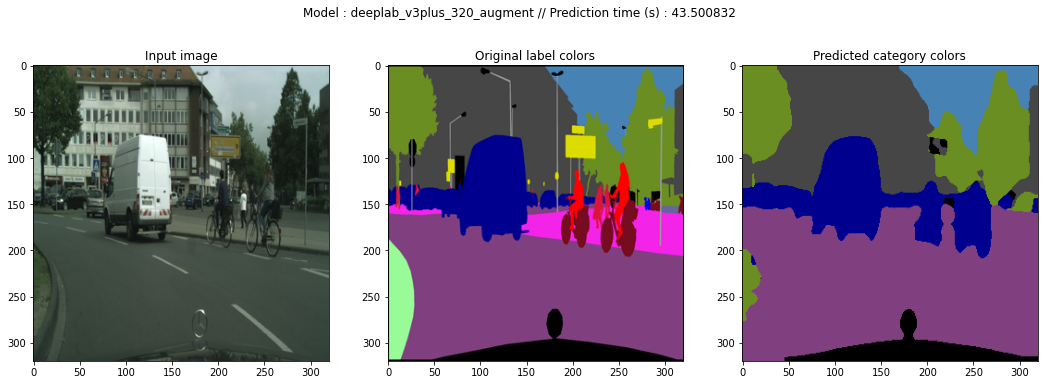

Sending request... Endpoint :  http://32452785-dd88-4390-b673-9a15994afc10.westeurope.azurecontainer.io/score
Response recieved... Status code :  504


Error: Invalid base64-encoded string: number of data characters (93) cannot be 1 more than a multiple of 4

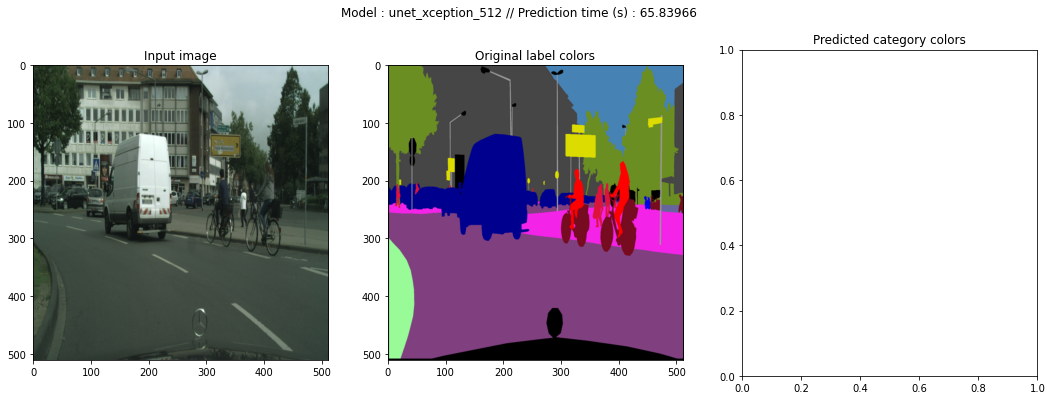

In [6]:
import base64
import json
import os
from io import BytesIO
from pathlib import Path

import numpy as np
import requests
from dotenv import dotenv_values
from matplotlib import pyplot as plt
from PIL import Image

# Get the model
model_names = [
    "unet_xception_64_augment",
    "deeplab_v3plus_80_augment",
    "unet_xception_128",
    "deeplab_v3plus_160",
    "unet_xception_256_augment",
    "deeplab_v3plus_320_augment",
    "unet_xception_512",
    "deeplab_v3plus_640",
]


# Get the images
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Get a random image index
rand_idx = np.random.randint(0, len(val_input_img_paths))


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    # Request data goes here
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))

    for model_name in model_names:
        # Set the model input size
        model_input_size = int(
            model_name.replace("_augment", "").split("_")[-1]
        )
        img_size = (model_input_size, model_input_size)

        # Call the inference endpoint
        inference_config = dotenv_values(Path(f"../.env.{model_name}"))
        url = inference_config["AZURE_INFERENCE_ENDPOINT"]
        headers = {
            "Content-Type": "application/json",
            "Authorization": (
                "Bearer " + inference_config["AZURE_INFERENCE_KEY"]
            ),
        }

        print("Sending request... Endpoint : ", url)
        r = requests.post(url, headers=headers, data=payload)
        print("Response recieved... Status code : ", r.status_code)
        result = r.content
        time = r.elapsed.total_seconds()

        # Plot the image, ground truth and prediction
        fig, ax = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(18, 6),
        )
        fig.suptitle(f"Model : {model_name} // Prediction time (s) : {time}")

        ax[0].title.set_text("Input image")
        val_img = Image.open(val_input_img_paths[rand_idx]).resize(img_size)
        ax[0].imshow(val_img)

        ax[1].title.set_text("Original label colors")
        val_colors = Image.open(val_label_colors_img_paths[rand_idx]).resize(
            img_size
        )
        ax[1].imshow(val_colors)

        ax[2].title.set_text("Predicted category colors")
        ax[2].imshow(Image.open(BytesIO(base64.b64decode(result))))

        plt.show()
